# Machine Learning for Multibody System Dynamics

## **Session 1-2:** Example of linear oscillator surrogate model

> Details: This file uses previously created data. 

Peter Manzl and Grzegorz Orzechowski

## Import packages and set seeds

In [1]:
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# manually setting a seed 
np.random.seed(0)
torch.manual_seed(0)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Load Data from file

Data contains the following fields:
- `inputsTraining`
- `targetsTraining`
- `inputsTest`
- `targetsTest`

We’ll read them into pyTorch tensors, using `float32` and inspect shapes.

- **input**: $\boldsymbol{x} = [x_0, \dot{x}_0, F_0, \ldots,  F_{n-1}]^T$
- **output**: $\boldsymbol{y} = [x_1, \ldots, x_n]^T$  with $x_i = x(t=i\cdot h)$; $h = 0.5/64$
- note that the force is scaled by 1/2000 to normalize the input vector.

In [2]:
myData = np.load('../data/LinearOscillatorT256-64s64randomExcitationmkd0_test.npy', allow_pickle=True).item()

inputsTraining = torch.tensor(myData['inputsTraining'], dtype=torch.float32)
targetsTraining = torch.tensor(myData['targetsTraining'], dtype=torch.float32)
inputsTest= torch.tensor(myData['inputsTest'], dtype=torch.float32)
targetsTest = torch.tensor(myData['targetsTest'], dtype=torch.float32) 

nTraining =  myData['inputsTraining'].shape[0]
nTest = myData['inputsTest'].shape[0]

print('dataset size training: {} and validation: {}.'.format(nTraining, nTest))
print('input: {}, output: {}'.format(np.array(inputsTraining[0].shape), np.array(targetsTraining[0].shape)))

dataset size training: 256 and validation: 64.
input: [66  1], output: [64  1]


## Time Vector for Plotting

We reconstruct the time‐axis `t_out` as in the original example:
- The sampling interval $h = \frac{0.5}{64}$.
- There are 64 output time‐steps.

In [3]:
h = 0.5/64
t_out = np.linspace(h, h*64, 64)

## Define Neural Network Surrogate

We use a single linear layer (no bias) to map inputs → outputs.  

$$\boldsymbol{y} = \boldsymbol{W} \boldsymbol{x}$$

Note: Here we explicitly use a linear layer as our neural network surrogate.

In [4]:
myNeuralNetwork = nn.Sequential(
                nn.Flatten(), 
                # flatten reduces the dimensionality to a single dimension. 
                # This can also be applied to the dataset instead of the neural network.  
                nn.Linear(np.prod(myData['inputShape']), np.prod(myData['outputShape']), 
                          bias=False),
                # here more layers can be added like e.g.:
                # nn.Sigmoid, nn.ReLU, nn.Tanh, etc. 
                # note that between activation functions linear layers should be added. 
                # Important: Take care that the size of layers fit together. 
                # Depending on how layers are arranged, different
                    # "neural network architectures" are configured. 
                nn.Unflatten(dim=1, unflattened_size= myData['outputShape']), 
                # restore the shape we want to have as output
                # instead of Flatten/unflatten, we could also do this operation on the data instead of the network. 
                )
# the Sequential object holds the neural network layers. 

### Visualize linear Layer

In the untrained state this is "just" noise and depends only on the initialization procedure.
Beacuse we have only one linear layer, we can show the matrix using a heatmap.

**Info:**  [initialization methods of pytorch](https://pytorch.org/docs/stable/nn.init.html)


In [5]:
 
def init_weights(m, init_type='Xavier'): 
    # per standard pytorch uses std 
    if isinstance(m, nn.Linear): 
        if init_type == 'Xavier_uniform': nn.init.xavier_uniform_(m.weight)
        if init_type == 'Xavier_normal':  nn.init.xavier_normal_(m.weight)
        if init_type == 'Kaiming_uniform':  nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # used in 
        if init_type == 'Kaiming_normal': nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None: 
            nn.init.constant_(m.bias, 0) # usually bias is initialized with zeros. 
# Linear layers are per default initialized
# myNeuralNetwork.apply(init_weights) # to apply specific initialization

Text(0, 0.5, 'output index')

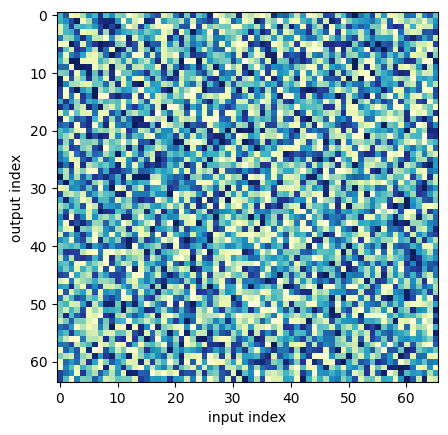

In [6]:
outTest_init = myNeuralNetwork(inputsTest).detach().numpy() # this will not fit well yet as it is not trained. 
plt.figure()
w_initialized = myNeuralNetwork[1].weight.detach()
plt.imshow(w_initialized, cmap="YlGnBu", interpolation='nearest')
plt.xlabel('input index')
plt.ylabel('output index')

## Hyperparameters

In deep learning Hyperparameters are _configuration variables_ for training and are required to reproduce results.  Hyperparameters are e.g.: 
- Size of training / validation / test dataset. 
- neural network architecture and settings: number and size of layers, activation function,  

For our case we have:
- **Optimizer:** ADAM with learning rate $5 \times 10^{-2}$
      Note that such a learning rate is very high for most examples.
- **Epochs:** 1200
- **Batch size:** 256

In [7]:
loss_fn = nn.MSELoss() # loss function used for optimization
optimizer = torch.optim.Adam(myNeuralNetwork.parameters(), lr=5e-2) # Adam optimizer. lr: learning rate. 
# optimizer = torch.optim.SGD(myNeuralNetwork.parameters(), lr=0.01, momentum=0.9) # SGD optimizer
# In this example stochastic gradient decent (SGD) does not work well. 

# create dataset structure and dataloader
batchSize = 256
nEpoch = 1200

## Prepare DataLoaders

We transpose inputsTraining and targetsTraining so that each batch is (inputDim, batchSize) → (outputDim, batchSize).

- Training DataLoader shuffles each epoch.
- Validation DataLoader does not shuffle.

In [8]:
# the dataloader shuffles data and returns n=batchSize samples
dataset_training = TensorDataset(inputsTraining, targetsTraining)
dataloader_training = DataLoader(dataset_training, batch_size=batchSize, shuffle=True)
dataset_validation= TensorDataset(inputsTraining, targetsTraining)
dataloader_validation = DataLoader(dataset_training, batch_size=batchSize, shuffle=False)


## Training Loop

In [9]:
loss_epoch, lossEpoch, lossValidation = [], [], []
t1 = time.time()
for j in range(nEpoch):     
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    running_loss = 0
    for i, data in enumerate(dataloader_training):
        # Every data instance obtained from the dataloader is an input + target pair
        inputs, target = data
        # zero gradients for every batch
        optimizer.zero_grad()
    
        # Make predictions for this batch
        outputs = myNeuralNetwork(inputs)
    
        # Compute the loss and its gradients
        loss = loss_fn(outputs, target)
        loss.backward() # backpropagation
    
        # Adjust weights
        optimizer.step()
    
        running_loss += float(loss)
    loss_epoch += [running_loss / (i+1)] # divide loss by number of items

    # strictly speaking when evaluated while training it is called "validation" set, 
    # otherwise "test" set.  
    if j % 10 == 0: 
        lossEpoch += [j]
        lossValidation += [loss_fn(myNeuralNetwork(inputsTest), 
                                   targetsTest).detach().numpy()]
lossValidation = np.array(lossValidation)
print('training took {} seconds'.format(time.time() - t1))

training took 0.936959981918335 seconds


## Combined Plot of Training and Validation Losses

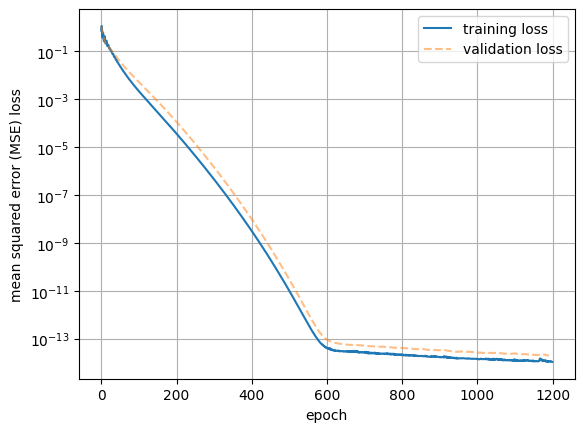

In [10]:
plt.figure()
plt.semilogy(loss_epoch, label='training loss')
plt.semilogy(lossEpoch, np.array(lossValidation), '--', label='validation loss', alpha=0.5)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mean squared error (MSE) loss')
plt.legend()

#### Note:
* The validation set can be used to identify overfitting: training loss might still decrease while validation loss increases. 
* Nonlinear activation functions (e.g. ReLu) would decrease accuracy in this case
* This accuracy can only be expected in the linear case.
* Due to non-deterministic nature of methods applied in deep learning, the minimum might not be always reached.
* When restarting training on the trained network the loss increases, thus accuracy declines.  


In this example a linear spring-damper system is trained with a single linear layer, thus (numerically) perfect fit is possible. While values vary strongly by application, in _real world_ examples loss might be closer to the $10^{-4}...10^{-8}$ range. 


## Visualize Weight Matrix

- Display a heatmap of the trained weight matrix of size (outputDim, inputDim).

Text(0, 0.5, 'output index')

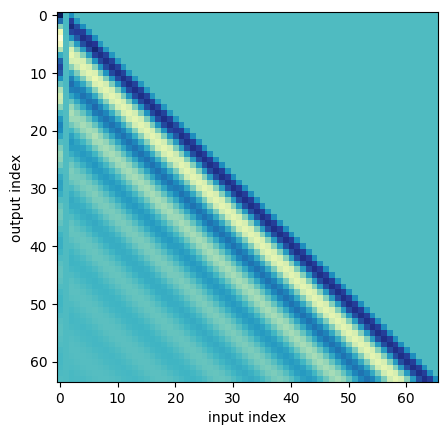

In [11]:
#%% 
plt.figure()
w_trained = myNeuralNetwork[1].weight.detach()
plt.imshow(w_trained, cmap="YlGnBu", interpolation='nearest')
plt.xlabel('input index')
plt.ylabel('output index')

#### Note
* When using only a single linear layer without bias, the weight matrix can be visualized directly.
* Each column i represents the system response for an input:
  * i=0: initial displacement $x_0$
  * i=1: initial velocity $\dot{x}_0$
  * i=2... n: constant Force at time $t=(i-2)h$

Due to the priciple of superposition for ordinary differential equation, the solutions can be superimposed - this is what happens at the network pass (=matrix multiplication). 


## Plot Weights for First Output Unit

Examine the weight vector corresponding to the first output dimension.

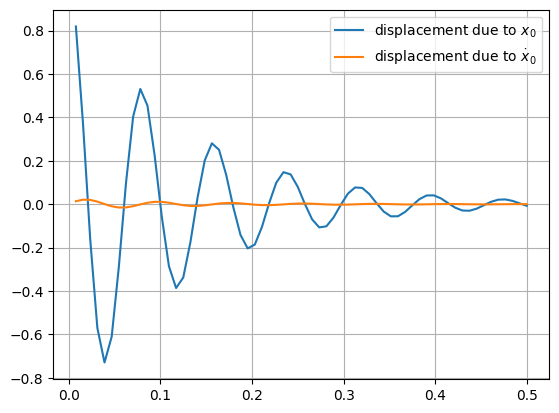

In [12]:
plt.figure()
plt.plot(t_out, w_trained[:,0], label='displacement due to $x_0$')
plt.plot(t_out, w_trained[:,1], label=r'displacement due to $\dot{x}_0$')
plt.legend()
plt.grid()

## Plot Predictions vs. True Signal (First Test Sample)

Compare the neural network’s predicted time-series against the true target for the first test sample.

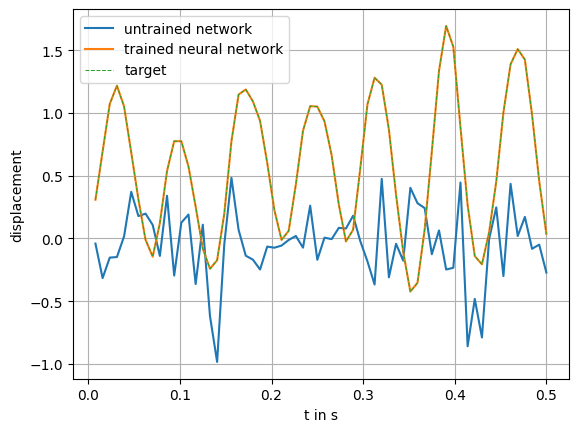

In [13]:
plt.figure()
outTest = myNeuralNetwork(inputsTest).detach().numpy()
plt.plot(t_out, outTest_init[0], label='untrained network') 
plt.plot(t_out, outTest[0], label='trained neural network', linewidth=1.5)
plt.plot(t_out, targetsTest[0], '--', label='target', linewidth=0.75)
plt.xlabel('t in s')
plt.ylabel('displacement')
plt.legend()
plt.grid()

#### Note: 
Neural networks generally work best for interpolation in the trained range and often fail to extrapolate outside. As in this example only a linear layer is used, it might generalize better. 

## Final Notes

- Training and validation losses are recorded during training.  
- You can adjust:
  - Learning rate (lr),
  - Number of epochs (nEpoch),
  - Batch size (batchSize),
  - Or try a different optimizer,
  to see how the surrogate model performance changes.  

Feel free to experiment with adding hidden layers or non-linear activations to improve the surrogate model’s approximation quality.

### Time for a break? 

Next, we will explore a nonlinear [Duffing Oscillator](../Session-2-SupervisedLearning/2-1_DuffingOscillator_regularization.ipynb) example.